In [2]:
# Library imports (see /Utilities/setup_env.py for full import list and figure setup)

from pathlib import Path
import sys

repo_root = Path.cwd().parents[0]  # .../Figure_analysis
repo_root = repo_root.parent       # repo root
sys.path.insert(0, str(repo_root))

from Figure_analysis.Utilities.setup_env import *

In [3]:
nerd_sqlite = '../../Core_nerd_analysis/nerd.sqlite'
rg_ids = [
    107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
    121,  # G detect just noisier
    122,
    91, 92, 93, 94, 95, 96, 97, 98,
    83, 84, 85, 86, 87, 88, 89, 90,
]

conn = sqlite3.connect(nerd_sqlite)
conn.row_factory = sqlite3.Row

query = """
SELECT *
FROM probe_tc_fits_view
WHERE fit_kind = 'round3_constrained'
  AND rg_id IN ({})
  AND rt_protocol = 'MRT'
ORDER BY rg_id
""".format(",".join(["?"] * len(rg_ids)))

df = pd.read_sql_query(query, conn, params=rg_ids)
conn.close()
df

,fit_run_id,rg_id,nt_id,fit_kind,rg_label,temperature,probe,probe_conc,rt_protocol,buffer_id,...,buffer_name,nt_site,nt_base,kobs,log_kobs,log_kdeg,log_kobs_err,log_kdeg_err,r2,metadata_json
0,341267,83,319,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,18,G,0.001931,-6.249909,-7.919755,0.463035,0.0,0.538972,"{""base"": ""G"", ""fmod_run_ids"": [107, 108, 109, ..."
1,341268,83,320,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,19,C,0.002738,-5.900700,-7.919755,0.365600,0.0,0.652434,"{""base"": ""C"", ""fmod_run_ids"": [107, 108, 109, ..."
2,341269,83,321,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,20,A,0.007279,-4.922822,-7.919755,0.053390,0.0,0.988832,"{""base"": ""A"", ""fmod_run_ids"": [107, 108, 109, ..."
3,341270,83,322,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,21,G,0.001045,-6.863388,-7.919755,0.346416,0.0,0.675961,"{""base"": ""G"", ""fmod_run_ids"": [107, 108, 109, ..."
4,341271,83,323,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,22,A,0.022169,-3.809064,-7.919755,0.040160,0.0,0.993770,"{""base"": ""A"", ""fmod_run_ids"": [107, 108, 109, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,339154,122,111,round3_constrained,80_2_12,80.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,32,G,0.001008,-6.899485,-2.886596,0.140019,0.0,0.910808,"{""base"": ""G"", ""fmod_run_ids"": [912, 913, 914, ..."
1188,339155,122,112,round3_constrained,80_2_12,80.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,33,G,0.001435,-6.546259,-2.886596,0.149163,0.0,0.900025,"{""base"": ""G"", ""fmod_run_ids"": [912, 913, 914, ..."
1189,339156,122,113,round3_constrained,80_2_12,80.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,34,G,0.001232,-6.699061,-2.886596,0.184688,0.0,0.854464,"{""base"": ""G"", ""fmod_run_ids"": [912, 913, 914, ..."
1190,339158,122,115,round3_constrained,80_2_12,80.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,36,G,0.002123,-6.154950,-2.886596,0.148678,0.0,0.900671,"{""base"": ""G"", ""fmod_run_ids"": [912, 913, 914, ..."


In [4]:
def calculate_dG(logkobs, logkadd):
    R = 1.9872036e-3  # kcal/(mol*K)
    T = 298.15  # K
    
    logKKp1 = logkobs - logkadd
    KKp1 = np.exp(logKKp1) # K / (K+1)
    K = KKp1 / (1 - KKp1)
    dG = -R * T * np.log(K)

    return dG

logkadd = -2.676278119425211 # logkadd
logkobs_r2_99 = -3.4806204679354953
logkobs_r2_55 = -7.240355294404981
logkobs_r2_39 = -7.503658411920693

dG_r2_99 = calculate_dG(logkobs_r2_99, logkadd)
dG_r2_55 = calculate_dG(logkobs_r2_55, logkadd)
dG_r2_39 = calculate_dG(logkobs_r2_39, logkadd)

print(f"dG for r2=0.99: {dG_r2_99:.2f} kcal/mol")
print(f"dG for r2=0.55: {dG_r2_55:.2f} kcal/mol")
print(f"dG for r2=0.39: {dG_r2_39:.2f} kcal/mol")

dG for r2=0.99: 0.13 kcal/mol
dG for r2=0.55: 2.70 kcal/mol
dG for r2=0.39: 2.86 kcal/mol


In [5]:
# C and at temperature 25 filter
df_c_25 = df[(df['nt_base'] == 'C') & (df['temperature'] == 25) & (df['construct_name'] == 'hiv_wt')]
df_c_25

# count how many above 0.3
count_above_30 = (df_c_25['r2'] >= 0.30).sum()
total_count = len(df_c_25)
fraction_above_30 = count_above_30 / total_count
print(f"Count of points with R^2 >= 0.30: {count_above_30}")
print(f"Total points: {total_count}")
print(f"Fraction of points with R^2 >= 0.30: {fraction_above_30:.2f}")

Count of points with R^2 >= 0.30: 9
Total points: 18
Fraction of points with R^2 >= 0.30: 0.50


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


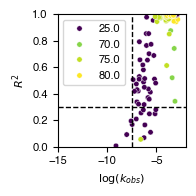

In [6]:
# filter to nt_base = C
df_c = df[df['nt_base'] == 'C']
df_c.to_csv('hiv_qc_C.csv')

fig, ax = plt.subplots(figsize=(2, 2))

# Main scatter plot
sns.scatterplot(data=df_c, x='log_kobs', y='r2', hue = 'temperature', palette = 'viridis', s = 15, ax=ax)
# set main axes labels

# draw horizontal line at r2 = 0.30
ax.axhline(0.30, color='black', linestyle='--', linewidth=1)

# draw vertical line at log_kobs = -7.5
ax.axvline(-7.5, color='black', linestyle='--', linewidth=1)

ax.set_xlabel(r'$\log(k_{obs})$')
ax.set_ylabel(r'$R^2$')

# set xlim -15 to -2
ax.set_xlim(-15, -2)
ax.set_ylim(0, 1)

# remove legend
ax.legend()

plt.tight_layout()
plt.savefig("r2_v_log_kobs_hiv_C.pdf")
plt.show()

In [7]:
# count of points with r2 >= 0.30
total_dfc = len(df_c)
count_r2_ge_30 = df_c[df_c['r2'] >= 0.30].shape[0]
print(f"Count of points with R^2 >= 0.30: {count_r2_ge_30}")
print(f"Total points: {total_dfc}")
print(f"Fraction of points with R^2 >= 0.30: {count_r2_ge_30 / total_dfc:.2f}")

Count of points with R^2 >= 0.30: 249
Total points: 280
Fraction of points with R^2 >= 0.30: 0.89


In [8]:
df_a = df[df['nt_base'] == 'A']
total_dfa = len(df_a)
count_r2_ge_30_a = df_a[df_a['r2'] >= 0.30].shape[0]
print(f"Count of points with R^2 >= 0.50 (A): {count_r2_ge_30_a}")
print(f"Total points (A): {total_dfa}")
print(f"Fraction of points with R^2 >= 0.50 (A): {count_r2_ge_30_a / total_dfa:.2f}")

Count of points with R^2 >= 0.50 (A): 144
Total points (A): 144
Fraction of points with R^2 >= 0.50 (A): 1.00


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


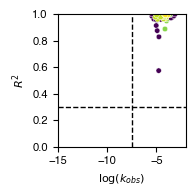

In [9]:
df_a = df[df['nt_base'] == 'A']
df_a.to_csv('hiv_qc_A.csv')

fig, ax = plt.subplots(figsize=(2, 2))

# Main scatter plot
sns.scatterplot(data=df_a, x='log_kobs', y='r2', hue = 'temperature', palette = 'viridis', s = 15, ax=ax)
# set main axes labels

# draw horizontal line at r2 = 0.30
ax.axhline(0.30, color='black', linestyle='--', linewidth=1)

# draw vertical line at log_kobs = -7.5
ax.axvline(-7.5, color='black', linestyle='--', linewidth=1)

ax.set_xlabel(r'$\log(k_{obs})$')
ax.set_ylabel(r'$R^2$')


# set xlim -15 to -2
ax.set_xlim(-15, -2)
ax.set_ylim(0, 1)

# remove legend
ax.legend().remove()

plt.tight_layout()
plt.savefig("r2_v_log_kobs_hiv_A.pdf")
plt.show()